# Self-supervised learning 
In this question, we will implement Simsiam a simple and effective Self-supervised learning (SSL) method. 

If you are running this code on Google Colab, uncomment the below cell and run it. Also, make sure you are saving the models in the right place that they can be used for resuming the training process or as a pretrained model. 

In [3]:
#@title Mount your Google Drive
%matplotlib inline
%load_ext autoreload
%autoreload 2

from google.colab import drive
drive.mount('/content/gdrive')

# install pytorch 1.9
# !pip install torch==1.9.0+cu102 torchvision==0.10.0+cu102 torchaudio==0.9.0 -f https://download.pytorch.org/whl/torch_stable.html

Mounted at /content/gdrive


In [4]:
%cd /content/gdrive/MyDrive/Udem/Sem2/Representation_Learning/IFT6135_Programming/assignment3/

/content/gdrive/MyDrive/Udem/Sem2/Representation_Learning/IFT6135_Programming/assignment3


In [5]:
import torch
from q2_sampler import svhn_sampler
from q2_model import Critic, Generator
from torch import optim
from torchvision.utils import save_image
from q2_solution import lp_reg, vf_wasserstein_distance, get_noise

In [ ]:
!python q2_solution.py

In [ ]:
data_root = './'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
n_iter = 50000 # N training iterations
n_critic_updates = 5 # N critic updates per generator update
lp_coeff = 10 # Lipschitz penalty coefficient
train_batch_size = 64
test_batch_size = 64
lr = 1e-4
beta1 = 0.5
beta2 = 0.9
z_dim = 100
cur_step = 0
display_step = 500
train_loader, valid_loader, test_loader = svhn_sampler(data_root, train_batch_size, test_batch_size)

generator = Generator(z_dim=z_dim).to(device)
critic = Critic().to(device)

optim_critic = optim.Adam(critic.parameters(), lr=lr, betas=(beta1, beta2))
optim_generator = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, beta2))

# COMPLETE TRAINING PROCEDURE
train_iter = iter(train_loader)
valid_iter = iter(valid_loader)
test_iter = iter(test_loader)
for i in range(n_iter):

  generator.train()
  critic.train()
  for _ in range(n_critic_updates):

    try:

      data = next(train_iter)[0].to(device)
    except Exception:
      train_iter = iter(train_loader)
      data = next(train_iter)[0].to(device)
    cur_batch_size = data.shape[0]
      # print(cur_batch_size)
    fake_noise = get_noise(cur_batch_size, z_dim, device=device)
    fake = generator(fake_noise).to(device)
      # critic_fake_pred = critic(fake).reshape(-1).to(device)
      # critic_real_pred = critic(data).reshape(-1).to(device)
      # print(data.shape)
      # print(critic_fake_pred.shape)
      # print(critic_real_pred.shape)
    gp = lp_reg(data, fake, critic).to(device)
      # print(gp.is_cuda)
    critic_loss = -(vf_wasserstein_distance(data, fake, critic)) + lp_coeff *gp
      
    critic.zero_grad()
      #To make a backward pass and retain the intermediary results
    critic_loss.backward(retain_graph=True)
      # Update optimizer
    optim_critic.step()
  gen_fake= critic(fake).reshape(-1)
  gen_loss = -torch.mean(gen_fake)
  generator.zero_grad()
  gen_loss.backward()
  # Update optimizer
  optim_generator.step()

    # Save sample images
  # if i % 100 == 0:
  #     print('gen_loss',gen_loss)
  #     print('critic loss', critic_loss)
  #     z = torch.randn(64, z_dim, device=device)
  #     imgs = generator(z)
      # save_image(imgs, f'q2/2.2/imgs_{i}.png', normalize=True, value_range=(-1, 1))
torch.save(generator, 'generator.pt')

Using downloaded and verified file: ./train_32x32.mat


KeyboardInterrupt: ignored

In [10]:
epsilons = [.05, .1, .15, .2, .25, .3]

In [12]:
%cd q2/2.2/

/content/gdrive/MyDrive/Udem/Sem2/Representation_Learning/IFT6135_Programming/assignment3/q2/2.2


In [34]:
# i=1
generator = torch.load('generator.pt')
z_dim = 100
z = torch.randn(64, z_dim, device=device)
z1=z
for i in range(z_dim):
  z1[:,i] = z[:,i] + 5
  imgs = generator(z1)
  save_image(imgs, f'imgs_{i}.png', normalize=True, value_range=(-1, 1))
  z1=z

In [29]:
imgs = generator(z)
save_image(imgs, f'imgs_original.png', normalize=True, value_range=(-1, 1))

In [ ]:
%cd q2/2.3/a/

/content/gdrive/MyDrive/Udem/Sem2/Representation_Learning/IFT6135_Programming/assignment3/q2/2.3/a


In [ ]:
alpha = torch.linspace(start=0, end=1, steps=11)
for i in range(0, len(alpha)):
  z0 = torch.randn(64, z_dim, device=device)
  z1 = torch.randn(64, z_dim, device=device)
  z = alpha[i]*z0 + (1 - alpha[i])*z1
  imgs = generator(z)
  save_image(imgs, f'imgs_{i}.png', normalize=True, value_range=(-1, 1))

In [ ]:
%cd b

/content/gdrive/MyDrive/Udem/Sem2/Representation_Learning/IFT6135_Programming/assignment3/q2/2.3/b


In [ ]:
alpha = torch.linspace(start=0, end=1, steps=11)
for i in range(0, len(alpha)):
  z0 = generator(torch.randn(64, z_dim, device=device))
  z1 = generator(torch.randn(64, z_dim, device=device))
  z = alpha[i]*z0 + (1 - alpha[i])*z1
  
  save_image(z, f'imgs_{i}.png', normalize=True, value_range=(-1, 1))

In [6]:
# import requirements

import math
import os
import random
import shutil


import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
import torch.utils.data.distributed
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from torch.utils.data import DataLoader
import torch.nn.functional as F

import numpy as np

from q3_solution  import SimSiam

from q3_misc import TwoCropsTransform, load_checkpoints, load_pretrained_checkpoints

model_names = sorted(name for name in models.__dict__
    if name.islower() and not name.startswith("__")
    and callable(models.__dict__[name]))

## Running on GPU
In Google Colab, you can run your code on device. This will be particularly important in CNN part of the assignment. To make sure the notebook is running on device, you can change the notebook settings with
* (EN) `Edit > Notebook Settings`
* (FR) `Modifier > Paramètres du notebook`

Be mindful not to use the device if your code does not need to run on GPU.

In [8]:
# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
# The parameters we will use

# general
seed = 2022
num_workers = 2
save_path = './'
resume = None #None or a path to a pretrained model (e.g. *.pth.tar')
start_epoch = 0
epochs = 102 #Number of epoches (for this question 100 is enough, however for 1000 epoches, you will get closer results to the original paper)

# data
dir ='./data'
batch_size = 1024

# Siamese backbone model
arch = "resnet18"
fix_pred_lr = True # fix the learning rate of the predictor network

#Simsiam params
dim=2048
pred_dim=512

# ablation experiments
stop_gradient=True # (True or False)
MLP_mode='None'#| '', 'no_pred_mlp

# optimizer
lr = 0.03
momentum = 0.9
weight_decay = 0.0005

# knn params
knn_k = 200 #k in kNN monitor
knn_t = 0.1 #softmax temperature in kNN monitor; could be different with moco-t

In [ ]:
# set seeds
random.seed(seed)
torch.manual_seed(seed)
cudnn.deterministic = True

In the next section we will build the Simsiam architecture as shown in this figure (from https://arxiv.org/pdf/2011.10566.pdf). 

# Question 3.1
The network includes an encoder `f` named `self.encoder` and a predictor h named `self.predictor`. 

* Complete the `SimSiam.forward` function  in `q3_solution.py`. This code will receive `x1` and `x2` as:

```
Input:
      x1: first views of images
      x2: second views of images
```
and compute the outputs of the network. which are as below:
```
z1, z2 = f(x1), f(x2) # projections, n-by-d
p1, p2 = h(z1), h(z2) # predictions, n-by-d
```


```
Output:
    p1, p2, z1, z2: predictors and targets of the network
    See Sec. 3 of https://arxiv.org/abs/2011.10566 for detailed notations
```



**Note**: Based on the `self.stop_gradient`, this function returns `z1` and `z2` with and without stop gradient. 

**Hint**: In Pytorch, to apply the stop-gradient operation to a variable let say `m`, You can detach it from the graph as `m.detach()`.

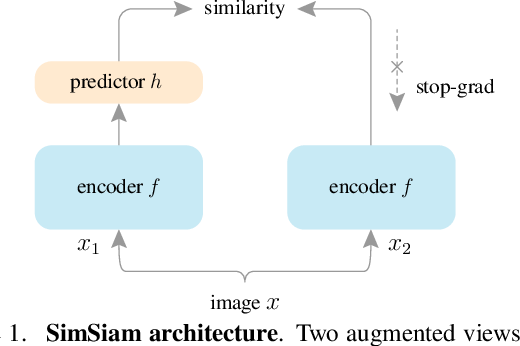

# Question 3.2

* Complete the `CosineSimilarity.forward` function  in `q3_solution.py`. This code compute cosine similarity between two inputs  `x1` and `x2`.

# Question 3.3

* Complete the `SimSiam.loss` function  in `q3_solution.py`. This code compute the Simsiam loss:

```
L = D(p1, z2)/2 + D(p2, z1)/2 
```
where `D` is negative cosine similarity.

Now we can initiate the model. 

In [ ]:
# Simsiam Model
print("=> creating model '{}'".format(arch))
model = SimSiam(models.__dict__[arch], dim, pred_dim, stop_gradient=False, MLP_mode='None')
# print(model)

model.to(device)

=> creating model 'resnet18'


SimSiam(
  (encoder): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_run

Now we set the learning rate (LR) of the model. We fix the LR of the predictor as it showed better performance in the original paper. Then we define the optimizer. 

In [ ]:
# define and set learning rates
init_lr = lr * batch_size / 256
if fix_pred_lr:
    optim_params = [{'params': model.encoder.parameters(), 'fix_lr': False},
                    {'params': model.predictor.parameters(), 'fix_lr': True}]
else:
    optim_params = model.parameters()

# define optimizer
optimizer = torch.optim.SGD(optim_params, init_lr,
                            momentum=momentum,
                            weight_decay=weight_decay)


In [ ]:
# We can resume from a previous checkpoint
if resume:
    model, optimizer, start_epoch = load_checkpoints(os.path.join(resume),model,optimizer,device)

# Dataset and dataloader for Siamese network

In this question, you will work on object classification task of CIFAR10 dataset. We use Pytorch CIFAR10 Dataset to download the dataset so you do not need to download it separately.  This dataset consist of high dimensional images $\mathcal{X} \subset \mathbb{R}^{32\times32\times3}$ of 10 classes. We provide samplers to generate the different distributions that you will need for this question.


In [ ]:
# define train and test augmentations for pretraining step 
train_transform = [
    transforms.RandomResizedCrop(32, scale=(0.08, 1.)), 
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomApply([transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)], p=0.8),
    transforms.RandomGrayscale(p=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])]

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])])

# datasets and loaders
train_data = datasets.CIFAR10(root=dir, train=True, transform=TwoCropsTransform(transforms.Compose(train_transform)), download=True)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True, drop_last=True)

memory_data = datasets.CIFAR10(root=dir, train=True, transform=test_transform, download=True)
memory_loader = DataLoader(memory_data, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

test_data = datasets.CIFAR10(root=dir, train=False, transform=test_transform, download=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In the next cell, we define a train and test function for one epoch of data. We  use k nearest-neighbor (KNN) `knn_predict` to monitor the performance of the model. (see https://arxiv.org/abs/1805.01978 for more details).


In [ ]:
# train for one epoch 
def train(train_loader, model, optimizer, device):

    # switch to train mode
    model.train()

    losses = []
    for i, (images, _) in enumerate(train_loader):

        if device is not None:
            images[0] = images[0].to(device, non_blocking=True)
            images[1] = images[1].to(device, non_blocking=True)

        # compute output and loss
        p1, p2, z1, z2 = model(x1=images[0], x2=images[1])
        loss = model.loss(p1,p2,z1,z2,similarity_function='CosineSimilarity')

        losses.append(loss.item())

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return losses

# save checkpoints 
def save_checkpoint(state, is_best, filename='checkpoint.pth.tar'):
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, 'model_best.pth.tar')

# test using a knn monitor
def test(net, memory_data_loader, test_data_loader, device, knn_k, knn_t ):
    net.eval()
    classes = len(memory_data_loader.dataset.classes)
    total_top1, total_top5, total_num, feature_bank = 0.0, 0.0, 0, []
    with torch.no_grad():
        # generate feature bank
        for i, (data, target) in enumerate(memory_data_loader):
            feature = net(data.to(device,non_blocking=True))
            feature = F.normalize(feature, dim=1)
            feature_bank.append(feature)
        # [D, N]
        feature_bank = torch.cat(feature_bank, dim=0).t().contiguous()
        # [N]
        feature_labels = torch.tensor(memory_data_loader.dataset.targets, device=feature_bank.device)
        # loop test data to predict the label by weighted knn search
        for i, (data, target) in enumerate(test_data_loader):
            data, target = data.to(device,non_blocking=True), target.to(device,non_blocking=True)
            feature = net(data)
            feature = F.normalize(feature, dim=1)
            
            pred_labels = knn_predict(feature, feature_bank, feature_labels, classes, knn_k, knn_t)

            total_num += data.size(0)
            total_top1 += (pred_labels[:, 0] == target).float().sum().item()

    return total_top1 / total_num * 100

# knn monitor as in InstDisc https://arxiv.org/abs/1805.01978
# implementation follows http://github.com/zhirongw/lemniscate.pytorch and https://github.com/leftthomas/SimCLR
def knn_predict(feature, feature_bank, feature_labels, classes, knn_k, knn_t):
    # compute cos similarity between each feature vector and feature bank ---> [B, N]
    sim_matrix = torch.mm(feature, feature_bank)
    # [B, K]
    sim_weight, sim_indices = sim_matrix.topk(k=knn_k, dim=-1)
    # [B, K]
    sim_labels = torch.gather(feature_labels.expand(feature.size(0), -1), dim=-1, index=sim_indices)
    sim_weight = (sim_weight / knn_t).exp()

    # counts for each class
    one_hot_label = torch.zeros(feature.size(0) * knn_k, classes, device=sim_labels.device)
    # [B*K, C]
    one_hot_label = one_hot_label.scatter(dim=-1, index=sim_labels.view(-1, 1), value=1.0)
    # weighted score ---> [B, C]
    pred_scores = torch.sum(one_hot_label.view(feature.size(0), -1, classes) * sim_weight.unsqueeze(dim=-1), dim=1)

    pred_labels = pred_scores.argsort(dim=-1, descending=True)
    return pred_labels

# adjust LR
def adjust_learning_rate(optimizer, init_lr, epoch, epochs):
    """Decay the learning rate based on schedule"""
    cur_lr = init_lr * 0.5 * (1. + math.cos(math.pi * epoch / epochs))
    for param_group in optimizer.param_groups:
        if 'fix_lr' in param_group and param_group['fix_lr']:
            param_group['lr'] = init_lr
        else:
            param_group['lr'] = cur_lr



Now we are ready to pretraining the backbone network. 

# Question 3.4
* train a model for 200 epochs with and without gradient stopping and evaluated them. Plot training loss and Knn accuracy against training epochs. 

**Hint** To run the model without gradient-stopping you need to change `stop_gradient` to `False` and run the notebook. Also, you need to store the training loss and Knn accuracy for each step. 

In [ ]:
# train loop 
loss_plt = []
knn_acc = []
for epoch in range(start_epoch, epochs):

    adjust_learning_rate(optimizer, init_lr, epoch, epochs)

    # train for one epoch
    losses = train(train_loader, model, optimizer, device)
    print('Train Epoch: [{}/{}] Train Loss:{:.5f}'.format(epoch, epochs,np.array(losses).mean() ))
    loss_plt.append(np.array(losses).mean())

    # test every 10 epochs
    if epoch % 1==0:
        acc1 = test(model.encoder, memory_loader, test_loader, device, knn_k, knn_t)
        print('Test Epoch: [{}/{}] knn_Acc@1: {:.2f}%'.format(epoch, epochs, acc1))
        knn_acc.append(acc1)
    
    # save a checkpoint every 20 epochs
    # if epoch % 40 == 0:
    #     save_checkpoint({
    #         'epoch': epoch + 1,
    #         'arch': arch,
    #         'state_dict': model.state_dict(),
    #         'optimizer' : optimizer.state_dict(),
    #     }, is_best=False, filename=save_path + '/checkpoint_random_init_{:04d}.pth.tar'.format(epoch))


Train Epoch: [0/102] Train Loss:-0.98561
Test Epoch: [0/102] knn_Acc@1: 18.51%
Train Epoch: [1/102] Train Loss:-0.98915
Test Epoch: [1/102] knn_Acc@1: 10.08%
Train Epoch: [2/102] Train Loss:-0.99028
Test Epoch: [2/102] knn_Acc@1: 9.88%
Train Epoch: [3/102] Train Loss:-0.98876
Test Epoch: [3/102] knn_Acc@1: 10.07%
Train Epoch: [4/102] Train Loss:-0.99573
Test Epoch: [4/102] knn_Acc@1: 10.01%
Train Epoch: [5/102] Train Loss:-0.99150
Test Epoch: [5/102] knn_Acc@1: 11.04%
Train Epoch: [6/102] Train Loss:-0.98187
Test Epoch: [6/102] knn_Acc@1: 10.08%
Train Epoch: [7/102] Train Loss:-0.99588
Test Epoch: [7/102] knn_Acc@1: 10.00%
Train Epoch: [8/102] Train Loss:-0.99565
Test Epoch: [8/102] knn_Acc@1: 10.02%
Train Epoch: [9/102] Train Loss:-0.99702
Test Epoch: [9/102] knn_Acc@1: 10.01%
Train Epoch: [10/102] Train Loss:-0.99435
Test Epoch: [10/102] knn_Acc@1: 10.01%
Train Epoch: [11/102] Train Loss:-0.99669
Test Epoch: [11/102] knn_Acc@1: 10.07%
Train Epoch: [12/102] Train Loss:-0.99717
Test Ep

After the pretraining the network, we can evalute the model in a classification task. In the next cells we will load the backbone model and train an supervised linear classifier on frozen features. 

In [ ]:
import pandas as pd
df = pd.DataFrame()
df['epoch'] = [ i for i in range(start_epoch, epochs)]
df['loss_random_init'] = loss_plt
df['knn_acc_random_init'] = knn_acc
df.to_csv('q2/no_stopgd_pretrained.csv', index=False)

In [ ]:
# linear eval
print("=> creating model '{}'".format(arch))
model = models.__dict__[arch]()

# freeze all layers but the last fc
for name, param in model.named_parameters():
    if name not in ['fc.weight', 'fc.bias']:
        param.requires_grad = False

# init the fc layer
model.fc.weight.data.normal_(mean=0.0, std=0.01)
model.fc.bias.data.zero_()
print(model)

=> creating model 'resnet18'
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      

In [ ]:
# load the pre-trained model from previous steps
pretrained = './checkpoint_noStopg_0080.pth.tar'#
if pretrained:
    model, optimizer, start_epoch = load_pretrained_checkpoints(os.path.join(pretrained),model,optimizer,device)
if device is not None:
    model.to(device)

=> loading checkpoint './checkpoint_noStopg_0080.pth.tar'
=> loaded pre-trained model './checkpoint_noStopg_0080.pth.tar'


In [ ]:
# define loss function (criterion) and optimizer
criterion = nn.CrossEntropyLoss().to(device)

# optimize only the linear classifier
parameters = list(filter(lambda p: p.requires_grad, model.parameters()))
assert len(parameters) == 2  # fc.weight, fc.bias

optimizer = torch.optim.SGD(parameters, init_lr,
                            momentum=momentum,
                            weight_decay=weight_decay)

In [ ]:
# define train and test augmentation for linear evaluation 
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(32),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomApply([transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)], p=0.8),
    transforms.RandomGrayscale(p=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])])

train_dataset = datasets.CIFAR10(
    dir,
    transform=train_transform,
    download=True,
    train=True
    )
val_dataset = datasets.CIFAR10(
    dir,
    transform=val_transform,
    download=True,
    train=False
    )


train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, #(train_sampler is None),
    num_workers=num_workers, pin_memory=True) #, sampler=train_sampler)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=256, shuffle=False,
    num_workers=num_workers, pin_memory=True)



Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# train for one epoch
def train(train_loader, model, criterion, optimizer, device):

    """
    Switch to eval mode:
    Under the protocol of linear classification on frozen features/models,
    it is not legitimate to change any part of the pre-trained model.
    BatchNorm in train mode may revise running mean/std (even if it receives
    no gradient), which are part of the model parameters too.
    """
    model.eval()
    losses=[]
    top1=[]
    top5=[]
    for i, (images, target) in enumerate(train_loader):

        if device is not None:
            images = images.to(device, non_blocking=True)
        target = target.to(device, non_blocking=True)

        # compute output
        output = model(images)
        loss = criterion(output, target)

        # measure accuracy and record loss
        acc1, acc5 = accuracy(output, target, topk=(1, 5))
        losses.append(loss.item())
        top1.append(acc1[0].cpu())
        top5.append(acc5[0].cpu())

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return top1, losses

# validation
def validate(val_loader, model, criterion, device):

    # switch to evaluate mode
    model.eval()
    losses=[]
    top1=[]
    top5=[]
    with torch.no_grad():

        for i, (images, target) in enumerate(val_loader):
            if device is not None:
                images = images.to(device, non_blocking=True)
            target = target.to(device, non_blocking=True)

            # compute output
            output = model(images)
            loss = criterion(output, target)

            # measure accuracy and record loss
            acc1, acc5 = accuracy(output, target, topk=(1, 5))
            losses.append(loss.item())
            top1.append(acc1[0].cpu())
            top5.append(acc5[0].cpu())

    return top1, loss


def sanity_check(state_dict, pretrained_weights):
    """
    Linear classifier should not change any weights other than the linear layer.
    This sanity check asserts nothing wrong happens (e.g., BN stats updated).
    """
    print("=> loading '{}' for sanity check".format(pretrained_weights))
    checkpoint = torch.load(pretrained_weights, map_location="cpu")
    state_dict_pre = checkpoint['state_dict']

    for k in list(state_dict.keys()):
        # only ignore fc layer
        if 'fc.weight' in k or 'fc.bias' in k:
            continue

        # name in pretrained model
        k_pre = 'encoder.' + k[len('module.'):] \
            if k.startswith('module.') else 'encoder.' + k

        assert ((state_dict[k].cpu() == state_dict_pre[k_pre]).all()), \
            '{} is changed in linear classifier training.'.format(k)

    print("=> sanity check passed.")


def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

In [ ]:
# train for the classififcation task
loss_tr_s = []
knn_tr_s = []
loss_val = []
knn_val = []
for epoch in range(start_epoch, epochs):
    adjust_learning_rate(optimizer, init_lr, epoch, epochs)

    # train for one epoch
    acc1, losses = train(train_loader, model, criterion, optimizer,device)
    print('Train Epoch: [{}/{}] Train acc1:{:.2f}%'.format(epoch, epochs,np.array(acc1).mean() ))
    print('train loss:', np.array(losses).mean())
    loss_tr_s.append(np.array(losses).mean())
    knn_tr_s.append(np.array(acc1).mean())

    # evaluate on validation set
    acc1, loss = validate(val_loader, model, criterion, device)
    print('Val Epoch: [{}/{}] Val acc1:{:.2f}%'.format(epoch, epochs,np.array(acc1).mean() ))
    # loss_val.append(np.array(loss).mean())
    knn_val.append(np.array(acc1).mean())
    

Train Epoch: [0/102] Train acc1:9.88%
train loss: 5.047192802234572
Val Epoch: [0/102] Val acc1:11.69%
Train Epoch: [1/102] Train acc1:11.22%
train loss: 2.652997216399835
Val Epoch: [1/102] Val acc1:10.55%
Train Epoch: [2/102] Train acc1:11.49%
train loss: 2.4374823618908317
Val Epoch: [2/102] Val acc1:11.03%
Train Epoch: [3/102] Train acc1:11.61%
train loss: 2.404422390217684
Val Epoch: [3/102] Val acc1:11.81%
Train Epoch: [4/102] Train acc1:12.23%
train loss: 2.381388790753423
Val Epoch: [4/102] Val acc1:11.12%
Train Epoch: [5/102] Train acc1:11.96%
train loss: 2.4082788156003367
Val Epoch: [5/102] Val acc1:12.38%
Train Epoch: [6/102] Train acc1:12.37%
train loss: 2.414715966399835
Val Epoch: [6/102] Val acc1:13.37%
Train Epoch: [7/102] Train acc1:12.22%
train loss: 2.371754081881776
Val Epoch: [7/102] Val acc1:12.93%
Train Epoch: [8/102] Train acc1:12.49%
train loss: 2.3840660416350072
Val Epoch: [8/102] Val acc1:15.33%
Train Epoch: [9/102] Train acc1:12.71%
train loss: 2.378473637

In [ ]:
import pandas as pd
df = pd.DataFrame()
df['epoch'] = [ i for i in range(start_epoch, epochs)]
df['loss_no_st'] = loss_tr_s
df['knn_no_st'] = knn_tr_s
df['knn_val_no_st'] = knn_val
df.to_csv('classification_no_stopgd.csv', index=False)

In [ ]:
import pandas as pd
# dfsgd = pd.read_csv('classification_stopgd.csv')
# df = pd.read_csv('classification.csv')


In [ ]:
import matplotlib.pyplot as plt
# import numpy as np
df=pd.read_csv('stopgd_pretrained.csv')
df1 = pd.read_csv('q3/no_pred_mlp_pretrained.csv')
df2 = pd.read_csv('q3/random_init_pretrained.csv')
df3 = pd.read_csv('q3/nstopgd_pretrained.csv')

In [ ]:
df3

,epoch,loss_st,knn_acc_st
0,0,-0.514878,22.03
1,1,-0.931856,23.17
2,2,-0.934458,22.74
3,3,-0.970920,23.59
4,4,-0.972959,24.06
...,...,...,...
97,97,-0.997622,10.01
98,98,-0.997651,10.00
99,99,-0.997674,10.01
100,100,-0.997756,10.00


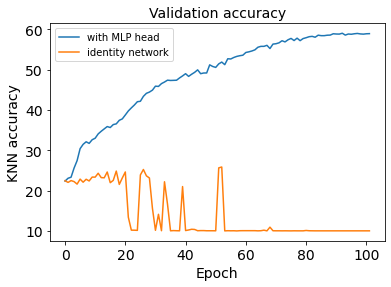

In [ ]:
plt.plot(df['epoch'], df['knn_acc_st'], label='with MLP head')  # Plot some data on the (implicit) axes.
plt.plot(df1['epoch'], df1['knn_acc_no_pred'], label='identity network')  # etc.
# plt.plot(df2['epoch'], df2['knn_acc_random_init'], label='fixed random init')
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('KNN accuracy', fontsize=14)
plt.title("Validation accuracy", fontsize=14)
plt.tick_params(labelsize=14)
plt.legend()
plt.savefig('knn2.jpg')

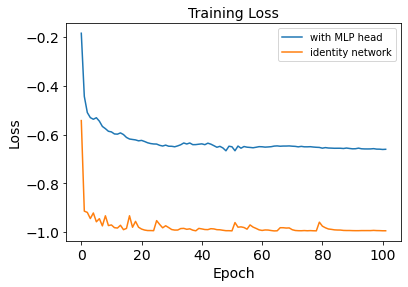

In [ ]:
plt.plot(df['epoch'], df['loss_st'], label='with MLP head')  # Plot some data on the (implicit) axes.
plt.plot(df1['epoch'], df1['loss_no_pred'], label='identity network')  # etc.
# plt.plot(df2['epoch'], df2['loss_random_init'], label='fixed random init')
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title("Training Loss", fontsize=14)
plt.tick_params(labelsize=14)
plt.legend()
plt.savefig('loss2.jpg')

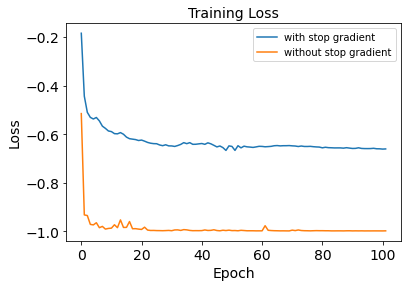

In [ ]:
plt.plot(df['epoch'], df['loss_st'], label='with stop gradient')  # Plot some data on the (implicit) axes.
plt.plot(df3['epoch'], df3['loss_st'], label='without stop gradient')  # etc.
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title("Training Loss", fontsize=14)
plt.tick_params(labelsize=14)
plt.legend()

# Question 3.5
Investigate the effect of the predictor network by experimenting the below settings. Plot training loss and Knn accuracy against training epochs.

* Remove the predictor by replacing it with an identity network.

**Note** To do the theis sub-question, you need to change the `MLP_mode`.
```
MLP_mode=None # None|'no_pred_mlp'| 'fixed_random_init'
```